In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product
from collections import defaultdict 

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from tqdm import tqdm
import pyLDAvis
import pyLDAvis.gensim as gensimvis


import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
%matplotlib inline

In [2]:
dictionary = Dictionary.load('data/Sotu/lda_sotu_50topics.id2word')

In [4]:
lda = LdaModel.load('data/Sotu/lda_sotu_50topics')

In [5]:
dictionary[67]

'satisfaction'

In [13]:
'satisfaction' in dictionary.token2id

True

In [6]:
dictionary.num_docs

5651

In [3]:
df = pd.read_csv('data/Sotu/sotu_addresses.csv')

In [4]:
df.head()

,speech,date
0,fellow-citizens of the senate and house of rep...,"January 8, 1790\n"
1,among the many interesting objects which will ...,"January 8, 1790\n"
2,there was reason to hope that the pacific meas...,"January 8, 1790\n"
3,"uniformity in the currency, weights, and measu...","January 8, 1790\n"
4,to the security of a free constitution it cont...,"January 8, 1790\n"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6564 entries, 0 to 6563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   speech  6564 non-null   object
 1   date    6564 non-null   object
dtypes: object(2)
memory usage: 102.7+ KB


In [6]:
df['date'] = df['date'].str.replace('\n', '')

In [7]:
df.head()

,speech,date
0,fellow-citizens of the senate and house of rep...,"January 8, 1790"
1,among the many interesting objects which will ...,"January 8, 1790"
2,there was reason to hope that the pacific meas...,"January 8, 1790"
3,"uniformity in the currency, weights, and measu...","January 8, 1790"
4,to the security of a free constitution it cont...,"January 8, 1790"


In [8]:
df['datetime'] = pd.to_datetime(df['date'])

In [9]:
stops_fi = set(stopwords.words('english'))

In [10]:
stops_fi = list(stops_fi)

In [16]:
def preprocessing(df, dct):
    # clean text and title and create new column "tokenized"
    tokens = df['speech'].apply(simple_preprocess, max_len=30)
    # remove stopwords
    tokens = tokens.apply(lambda x: [w for w in x if w in dct.token2id])
    
    return tokens


In [17]:
%%time
df['tokens'] = preprocessing(df, dictionary)

CPU times: user 1.99 s, sys: 34.7 ms, total: 2.02 s
Wall time: 2.03 s


In [18]:
df = df[df['datetime'].dt.year > 1806]

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407 entries, 0 to 6406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   speech    6407 non-null   object        
 1   date      6407 non-null   object        
 2   datetime  6407 non-null   datetime64[ns]
 3   tokens    6407 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 200.3+ KB


In [21]:
df.head()

,speech,date,datetime,tokens
0,the senate and house of representatives of the...,"October 27, 1807",1807-10-27,"[senate, house, representatives, united, state..."
1,some of the articles proposed might have been ...,"October 27, 1807",1807-10-27,"[articles, proposed, might, admitted, principl..."
2,to former violations of maritime rights anothe...,"October 27, 1807",1807-10-27,"[former, violations, maritime, rights, another..."
3,our peace with the several states on the coast...,"October 27, 1807",1807-10-27,"[peace, several, states, coast, barbary, appea..."
4,the appropriations of the last session for the...,"October 27, 1807",1807-10-27,"[appropriations, last, session, defense, port,..."


In [22]:
def group_year(df):
    groups = df.groupby(df.datetime.dt.year // 2)
    df['group_id'] = groups.ngroup()
#     for name, g in groups:
#         print(name)

    return df
        
        

In [23]:
df = group_year(df)

In [24]:
df.tail()

,speech,date,datetime,tokens,group_id
6402,a hopeful society depends on courts that deliv...,"January 31, 2006",2006-01-31,"[hopeful, society, depends, courts, deliver, e...",99
6403,a hopeful society expects elected officials to...,"January 31, 2006",2006-01-31,"[hopeful, society, expects, elected, officials...",99
6404,a hopeful society comes to the aid of fellow c...,"January 31, 2006",2006-01-31,"[hopeful, society, comes, fellow, citizens, ti...",99
6405,"fellow citizens, we've been called to leadersh...","January 31, 2006",2006-01-31,"[fellow, citizens, called, leadership, period,...",99
6406,may god bless america. (applause.),"January 31, 2006",2006-01-31,"[bless, america, applause]",99


In [61]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [62]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [25]:
# def get_docs_per_cluster(lda, corpus):
#     clusters = []
    
#     for doc in corpus:
#         topics = lda.get_document_topics(doc)
#         topics = [i[1] for i in topics]
#         top_id = np.argmax(topics)
#         clusters.append(top_id)
        
#     return clusters


def get_docs_per_cluster(lda, corpus):
    clusters = [list() for i in range(50)]
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc, minimum_probability=0.05)
        topics = [i[0] for i in topics]
        for topic in topics:
            clusters[topic].append(i)
            
    return clusters

In [95]:
clusters = get_docs_per_cluster(lda, corpus)

In [67]:
len(clusters)

50

In [20]:
def get_topic_term(lda, dictionary):
    topics = []
    
    for i in range(20):
        terms = lda.get_topic_terms(i, topn=20)
        words = []
        for t in terms:
            words.append(dictionary[t[0]])
        topics.append(words)
        
    return topics

In [21]:
#topic_terms = get_topic_term(lda, dictionary)

In [27]:
#topic_terms = pd.DataFrame(topic_terms, columns=list(range(20)))

In [28]:
# topic_terms.to_csv('data/topic_terms.csv', index=False)

In [68]:
#topic_terms

In [57]:
#topics = lda.get_document_topics(corpus[0])

In [59]:
#topics = [i[1] for i in topics]

In [64]:
#np.argmax(topics)

1

In [26]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokens'])]

In [27]:
model = Doc2Vec(vector_size=256, min_count=2, workers=4, dbow_words=1, negative=5)

In [28]:
%%time
model.build_vocab(documents)

CPU times: user 3.5 s, sys: 39.5 ms, total: 3.54 s
Wall time: 3.55 s


In [29]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=30)

CPU times: user 1min 27s, sys: 2.49 s, total: 1min 29s
Wall time: 29.9 s


In [30]:
def infer_d2v(docs, model):
    vecs = np.zeros((len(docs), model.vector_size))
    for i, doc in enumerate(docs):
        vecs[i] = model.infer_vector(doc)
        
    return vecs

In [31]:
vecs = infer_d2v(df['tokens'], model)

In [32]:
# train stt kmean
kmean = KMeans(n_clusters=20, random_state=2).fit(vecs)

In [33]:
def get_kmean_change(labels, df):
    changes = []    
    clusters = [list() for i in range(20)]
    
    # extract cluster ids
    for i, c in enumerate(labels):
        clusters[c].append(i)
    
    for c, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        counts = cluster.groupby('group_id').size()
        # counts = cluster['date'].value_counts().sort_index()
        # diff = times.diff().fillna(0)
        changes.append(counts)
        
    return changes, clusters

In [34]:
km_change, km_clusters = get_kmean_change(kmean.labels_, df)

In [35]:
def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()
    
def get_target(df):
    target = df[df['event'] != 'noise']['category'].iloc[0]
    return target

# def get_cluster_change(clusters, sample):
#     sample['cluster'] = clusters
#     n_cluster = sample['cluster'].nunique()
#     changes = []
    
#     for g, cluster in sample.groupby('cluster'):
#         # count and sort by timeline
#         counts = cluster['time'].value_counts().sort_index()
#         # print(cluster['time'].nunique())
#         maj_class = cluster['category'].value_counts(normalize=True).index[0]
#         # diff = times.diff().fillna(0)
#         changes.append((g, maj_class, counts))
        
#     return changes


def get_cluster_change(clusters, df):
    changes = []
    
    for i, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        counts = cluster['group_id'].value_counts().sort_index()
        #maj_class = cluster['category'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append(counts)
        
    return changes


def visualize_changes(changes):    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    distance = 0

    for cluster, counts in enumerate(changes):
        val = counts.values + distance
        ax.plot(counts.index, val, label=cluster)
        distance += 20
    
    ax.set(xlabel='Time', ylabel='Counts')
    ax.legend()
    ax.set_xticks(range(0, 100, 2))
    ax.grid()

    plt.show()

In [32]:
#visualize_trending(sample)

In [33]:
#target = get_target(sample)

In [36]:
#changes = get_cluster_change(clusters, df)

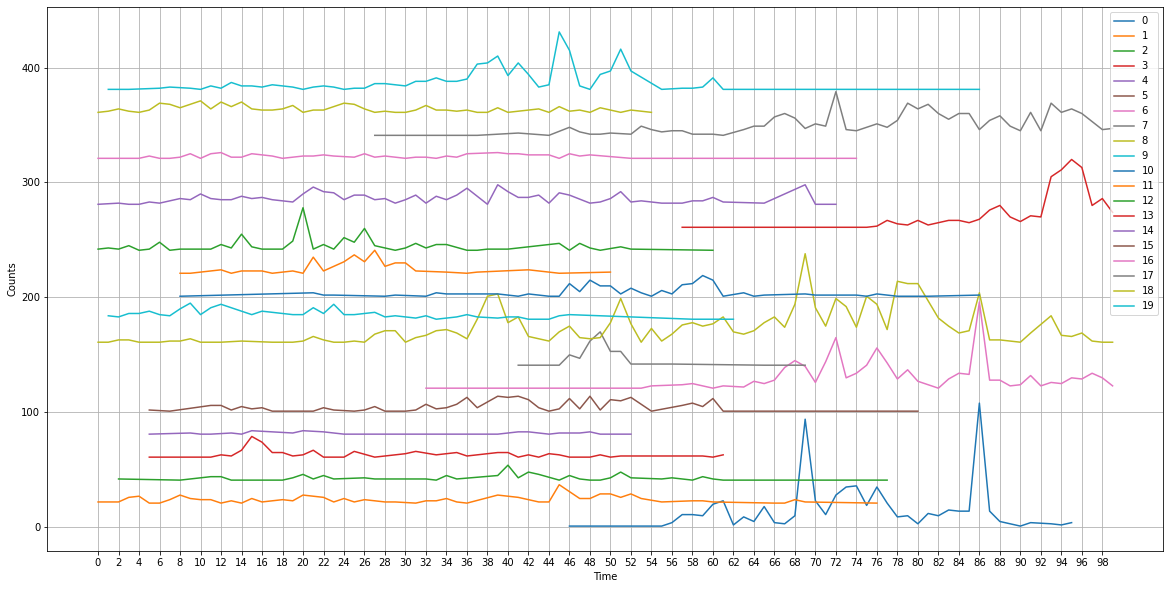

In [37]:
visualize_changes(km_change)

In [40]:
df.head()

,speech,date,datetime,tokens,group_id
0,the senate and house of representatives of the...,"October 27, 1807",1807-10-27,"[the, senate, and, house, of, representatives,...",0
1,some of the articles proposed might have been ...,"October 27, 1807",1807-10-27,"[some, of, the, articles, proposed, might, hav...",0
2,to former violations of maritime rights anothe...,"October 27, 1807",1807-10-27,"[to, former, violations, of, maritime, rights,...",0
3,our peace with the several states on the coast...,"October 27, 1807",1807-10-27,"[our, peace, with, the, several, states, on, t...",0
4,the appropriations of the last session for the...,"October 27, 1807",1807-10-27,"[the, appropriations, of, the, last, session, ...",0


In [38]:
def get_articles_cluster(df, clusters, cluster_id, time_range=(0, 100)):
    ids = clusters[cluster_id]
    articles = df.iloc[ids]
    filtered = articles[(articles['group_id'] >= time_range[0]) & (articles['group_id'] <= time_range[1])]
    
    return filtered
    
    

In [39]:
check = get_articles_cluster(df, km_clusters, 13, (85, 87))

In [45]:
pd.set_option('display.max_colwidth', -1)

In [79]:
rid = np.random.randint(check.shape[0])
check.iloc[rid]['speech']

'our current welfare system is long overdue for serious reform; the system is wasteful and not fully effective. the legislation i have proposed will help eliminate inequities by establishing a national minimum benefit, and by directly relating benefit levels to the poverty threshold. it will reduce program complexity, which leads to inefficiency and waste, by simplifying and coordinating administration among different programs.  i urge the congress to take action in this area along the lines i have recommended.  child welfare'

In [82]:
check.tail(5)

,speech,date,datetime,tokens,group_id
5710,"the early evidence of that recovery has started coming in. housing starts for the fourth quarter of 1982 were up 45 percent from a year ago, and housing permits, a sure indicator of future growth, were up a whopping 60 percent. we're witnessing an upsurge of productivity and impressive evidence that american industry will once again become competitive in markets at home and abroad, ensuring more jobs and better incomes for the nation's work force. but our confidence must also be tempered by realism and patience. quick fixes and artificial stimulants repeatedly applied over decades are what brought us the inflationary disorders that we've now paid such a heavy price to cure. the permanent recovery in employment, production, and investment we seek won't come in a sharp, short spurt. it'll build carefully and steadily in the months and years ahead. in the meantime, the challenge of government is to identify the things that we can do now to ease the massive economic transition for the american people.","January 25, 1983",1983-01-25,"[the, early, evidence, of, that, recovery, has, started, coming, in, housing, starts, for, the, fourth, quarter, of, were, up, percent, from, year, ago, and, housing, permits, sure, indicator, of, future, growth, were, up, whopping, percent, we, re, witnessing, an, upsurge, of, productivity, and, impressive, evidence, that, american, industry, will, once, again, become, competitive, in, markets, at, home, and, abroad, ensuring, more, jobs, and, better, incomes, for, the, nation, work, force, but, our, confidence, must, also, be, tempered, by, realism, and, patience, quick, fixes, and, artificial, stimulants, repeatedly, applied, over, decades, are, what, brought, us, the, inflationary, disorders, that, we, ve, ...]",87
5712,"during the 1970's, the share of our national income devoted to this domestic spending increased by more than 60 percent, from 10 cents out of every dollar produced by the american people to 16 cents. in spite of all our economies and efficiencies, and without adding any new programs, basic, necessary domestic spending provided for in this year's budget will grow to almost a trillion dollars over the next 5 years. the deficit problem is a clear and present danger to the basic health of our republic. we need a plan to overcome this danger--a plan based on these principles. it must be bipartisan. conquering the deficits and putting the government's house in order will require the best effort of all of us. it must be fair. just as all will share in the benefits that will come from recovery, all would share fairly in the burden of transition. it must be prudent. the strength of our national defense must be restored so that we can pursue prosperity and peace and freedom while maintaining our commitment to the truly needy. and finally, it must be realistic. we can't rely on hope alone. with these guiding principles in mind, let me outline a four-part plan to increase economic growth and reduce deficits.","January 25, 1983",1983-01-25,"[during, the, the, share, of, our, national, income, devoted, to, this, domestic, spending, increased, by, more, than, percent, from, cents, out, of, every, dollar, produced, by, the, american, people, to, cents, in, spite, of, all, our, economies, and, efficiencies, and, without, adding, any, new, programs, basic, necessary, domestic, spending, provided, for, in, this, year, budget, will, grow, to, almost, trillion, dollars, over, the, next, years, the, deficit, problem, is, clear, and, present, danger, to, the, basic, health, of, our, republic, we, need, plan, to, overcome, this, danger, plan, based, on, these, principles, it, must, be, bipartisan, conquering, the, deficits, and, ...]",87
5714,"third, i will adjust our program to restore america's defenses by proposing $55 billion in defense savings over the next 5 years. these are savings recommended to me by the secretary of defense, who has assured me they can

In [73]:
check.to_csv('data/cluster_check.csv', index=False)

In [40]:
pickle.dump(km_change, open('models/stt/sotu_change_km.pkl', 'wb'))

In [99]:
changes[0]

11     2
14     1
15     1
17     1
20     1
21     1
28     1
31     1
34     4
36     2
39     1
41     1
42     1
48     1
49     2
50     1
52     1
56     1
57     1
60     1
62     1
64     2
65     2
67     2
68     1
69     6
70     5
71     1
72     3
73     2
74     6
75     5
76     6
77     7
78     6
79     7
80     5
81     5
82     6
83     2
84     4
85     2
86    13
87     2
88     3
89     1
90     1
91     4
93     9
94    14
95    17
96    13
98     4
Name: group_id, dtype: int64

In [2]:
def check_missing_lda():
    root = 'models/lda/lda_models'
    missing = []
    
    for i in range(2000):
        exist = os.path.isfile(os.path.join(root, 'lda_sample_' + str(i)))
        if not exist:
            missing.append(i)
    return missing

In [3]:
missing = check_missing_lda()

In [5]:
print(missing)

[139, 141, 1147, 1148, 1150, 1151, 1153, 1155, 1156, 1160, 1164, 1183, 1185, 1186, 1193, 1194, 1197, 1198, 1447, 1449, 1455, 1456, 1457, 1460, 1461]
